
# Project Title : Analysis of COVID-19 vaccine sentiments and opinions on Twitter


Import library and download packages required for project

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import itertools
import collections
import string
pd.set_option("display.max_colwidth", 200) 


import nltk # for text manipulation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon') # Download the VADER lexicon


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# Connect Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#Reading the dataset drom excel file
data_read =  pd.read_excel("drive/MyDrive/Twitter Project/Final Dataset/Covaxin.xlsx")

In [4]:
#Tranfer dataset to anaother variable for further processing
data_df = data_read

**Exploring Our Dataset**

In [5]:
#Checking dataset varaiable
data_df.head()

,id,date,content,username
0,1277710000000000000,2020-06-29,"Indiaâ€™s first potential #COVID19 vaccine, â€œ#COVAXINâ€, the first to be developed in India, has been given DCGI (Drug Controller General of India) approval for Phase I and II human clinical tr...",aboyobbhuyan
1,1277690000000000000,2020-06-29,"#Covaxinâ€” In a major breakthrough, Indiaâ€™s first COVID19 #Vaccine developed by #BharatBiotech in collaboration wid ICMR-NIV gets DGCI approval for Phase I, II human trials.\n#CoronaVirusUpdate...",itskushalroy
2,1277670000000000000,2020-06-29,#covaxin,riksag
3,1277660000000000000,2020-06-29,"#BREAKING : Union Health Min approves clinical human trails for #Indiaâ€™s 1st #COVID19 vaccine, being developed by Bharath Biotech n @icmr_niv - #Covaxin, they successfully tested on animals. Bes...",livingforpeace2
4,1277650000000000000,2020-06-29,"#COVAXIN First Indian #vaccine developed by #BharatBioTech @BharatBiotech Hope everything goes well and we get the #VaccinesWork ASAP!!!, As i know it was developed in #Hyderabad #SaveHumanRace ht...",im_prashanth_


In [6]:
#Renaming Column headers
data_df.rename(columns = {'content':'OriginalTweet','date':'Date','username':'Username','id':'Id'}, inplace = True)

In [7]:
data_df.head(2)

,Id,Date,OriginalTweet,Username
0,1277710000000000000,2020-06-29,"Indiaâ€™s first potential #COVID19 vaccine, â€œ#COVAXINâ€, the first to be developed in India, has been given DCGI (Drug Controller General of India) approval for Phase I and II human clinical tr...",aboyobbhuyan
1,1277690000000000000,2020-06-29,"#Covaxinâ€” In a major breakthrough, Indiaâ€™s first COVID19 #Vaccine developed by #BharatBiotech in collaboration wid ICMR-NIV gets DGCI approval for Phase I, II human trials.\n#CoronaVirusUpdate...",itskushalroy


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19738 entries, 0 to 19737
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             19738 non-null  object        
 1   Date           19738 non-null  datetime64[ns]
 2   OriginalTweet  19738 non-null  object        
 3   Username       14906 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 616.9+ KB


In [9]:
data_df.shape

(19738, 4)

In [10]:
# Check null values
data_df.isnull().sum()

Id                  0
Date                0
OriginalTweet       0
Username         4832
dtype: int64

In [11]:
#Removing Duplicate tweets 
data_df = data_df.drop_duplicates('OriginalTweet')
print(data_df.shape)


(17733, 4)


**Unique Values In Each Feature Coulmn**

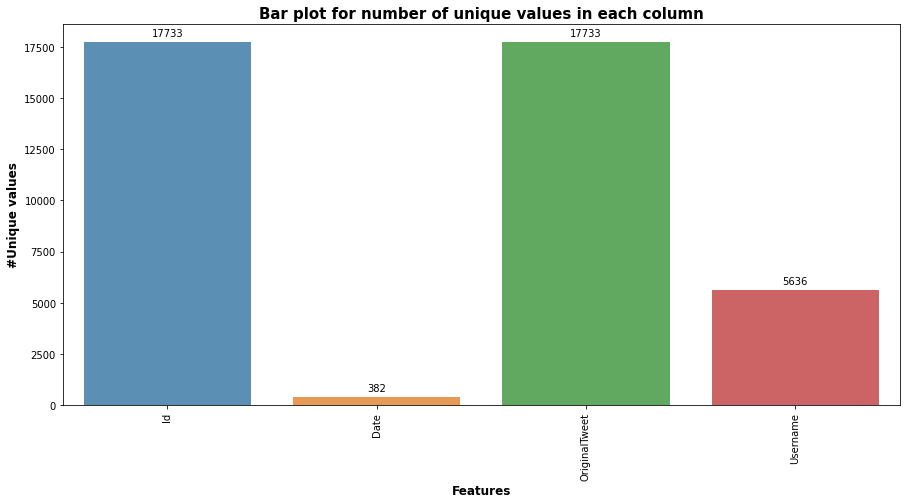

In [12]:
unique_df = pd.DataFrame()
unique_df['Features'] = data_df.columns
unique=[]
for i in data_df.columns:
    unique.append(data_df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [13]:
#Checking timeline of tweets
data_df['Date'].sort_values()

0       2020-06-29
19      2020-06-29
18      2020-06-29
16      2020-06-29
15      2020-06-29
           ...    
19703   2021-12-17
19704   2021-12-17
19705   2021-12-17
19692   2021-12-17
19737   2021-12-17
Name: Date, Length: 17733, dtype: datetime64[ns]

**Top 10 dates of tweet**

In [14]:
Most_tweet_Date = data_df['Date'].value_counts().head(10)
rc={'figure.figsize':(12,8)}
sns.set_style('white')

Most_tweet_Date_df=pd.DataFrame(Most_tweet_Date)
Most_tweet_Date_df.reset_index(inplace=True)
Most_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Most_tweet_Date_df

,Date,Date_Count
0,2021-11-24,290
1,2021-11-20,243
2,2021-11-03,214
3,2021-06-30,211
4,2021-07-03,206
5,2021-11-22,188
6,2021-03-01,181
7,2021-04-21,180
8,2021-11-23,169
9,2021-05-25,155


[Text(0, 0, '2021-11-24T00:00:00.000000000'),
 Text(0, 0, '2021-11-20T00:00:00.000000000'),
 Text(0, 0, '2021-11-03T00:00:00.000000000'),
 Text(0, 0, '2021-06-30T00:00:00.000000000'),
 Text(0, 0, '2021-07-03T00:00:00.000000000'),
 Text(0, 0, '2021-11-22T00:00:00.000000000'),
 Text(0, 0, '2021-03-01T00:00:00.000000000'),
 Text(0, 0, '2021-04-21T00:00:00.000000000'),
 Text(0, 0, '2021-11-23T00:00:00.000000000'),
 Text(0, 0, '2021-05-25T00:00:00.000000000')]

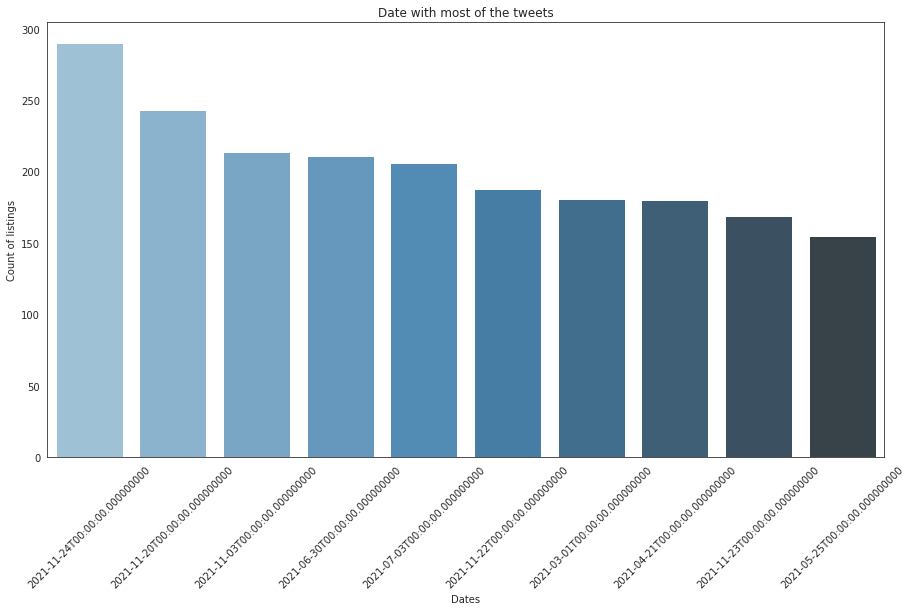

In [15]:
fig = plt.figure(figsize=(15, 8))
viz_1=sns.barplot(x="Date", y="Date_Count", data=Most_tweet_Date_df,
                 palette='Blues_d')
viz_1.set_title('Date with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Dates')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

**Bottom 10 dates of tweet**

In [16]:
Least_tweet_Date = data_df['Date'].value_counts().tail(10)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

Least_tweet_Date_df=pd.DataFrame(Least_tweet_Date)
Least_tweet_Date_df.reset_index(inplace=True)
Least_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Least_tweet_Date_df

,Date,Date_Count
0,2021-03-29,4
1,2021-09-26,4
2,2020-12-24,4
3,2021-09-03,4
4,2021-03-15,4
5,2020-07-14,4
6,2020-07-11,4
7,2021-10-03,4
8,2020-10-24,4
9,2021-03-21,4


**Data Preprocessing**

In [17]:
#Storing tweets in different column for text processing
data_df['CleanTweet'] = data_df['OriginalTweet']
data_df['CleanTweet'].head(5)

0    Indiaâ€™s first potential #COVID19 vaccine, â€œ#COVAXINâ€, the first to be developed in India, has been given DCGI (Drug Controller General of India) approval for Phase I and II human clinical tr...
1    #Covaxinâ€” In a major breakthrough, Indiaâ€™s first COVID19 #Vaccine developed by #BharatBiotech in collaboration wid ICMR-NIV gets DGCI approval for Phase I, II human trials.\n#CoronaVirusUpdate...
2                                                                                                                                                                                                   #covaxin
3    #BREAKING : Union Health Min approves clinical human trails for #Indiaâ€™s 1st #COVID19 vaccine, being developed by Bharath Biotech n @icmr_niv - #Covaxin, they successfully tested on animals. Bes...
4    #COVAXIN First Indian #vaccine developed by #BharatBioTech @BharatBiotech Hope everything goes well and we get the #VaccinesWork ASAP!!!, As i know it was developed in #Hydera

In [18]:
#Converting tweet in lower case
data_df['CleanTweet'] = data_df.CleanTweet.str.lower()
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential #covid19 vaccine, â€œ#covaxinâ€, the first to be developed in india, has been given dcgi (drug controller general of india) approval for phase i and ii human clinical tr...
1    #covaxinâ€” in a major breakthrough, indiaâ€™s first covid19 #vaccine developed by #bharatbiotech in collaboration wid icmr-niv gets dgci approval for phase i, ii human trials.\n#coronavirusupdate...
2                                                                                                                                                                                                   #covaxin
3    #breaking : union health min approves clinical human trails for #indiaâ€™s 1st #covid19 vaccine, being developed by bharath biotech n @icmr_niv - #covaxin, they successfully tested on animals. bes...
4    #covaxin first indian #vaccine developed by #bharatbiotech @bharatbiotech hope everything goes well and we get the #vaccineswork asap!!!, as i know it was developed in #hydera

In [19]:
#Removing URL or https link from  tweets
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_URLs(x))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential #covid19 vaccine, â€œ#covaxinâ€, the first to be developed in india, has been given dcgi (drug controller general of india) approval for phase i and ii human clinical tr...
1    #covaxinâ€” in a major breakthrough, indiaâ€™s first covid19 #vaccine developed by #bharatbiotech in collaboration wid icmr-niv gets dgci approval for phase i, ii human trials.\n#coronavirusupdate...
2                                                                                                                                                                                                   #covaxin
3    #breaking : union health min approves clinical human trails for #indiaâ€™s 1st #covid19 vaccine, being developed by bharath biotech n @icmr_niv - #covaxin, they successfully tested on animals. bes...
4        #covaxin first indian #vaccine developed by #bharatbiotech @bharatbiotech hope everything goes well and we get the #vaccineswork asap!!!, as i know it was developed in #hy

In [20]:
#Cleaning and removing punctuations
def cleaning_punctuations(text):
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '',punctuations_list)
    return text.translate(translator)
data_df['CleanTweet']= data_df['CleanTweet'].apply(lambda x: cleaning_punctuations(x))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential covid19 vaccine â€œcovaxinâ€ the first to be developed in india has been given dcgi drug controller general of india approval for phase i and ii human clinical trials th...
1    covaxinâ€” in a major breakthrough indiaâ€™s first covid19 vaccine developed by bharatbiotech in collaboration wid icmrniv gets dgci approval for phase i ii human trials\ncoronavirusupdates corona...
2                                                                                                                                                                                                    covaxin
3    breaking  union health min approves clinical human trails for indiaâ€™s 1st covid19 vaccine being developed by bharath biotech n icmrniv  covaxin they successfully tested on animals best wishes bt...
4                   covaxin first indian vaccine developed by bharatbiotech bharatbiotech hope everything goes well and we get the vaccineswork asap as i know it was developed in h

In [21]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_repeating_char(x))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential covi19 vaccine â€œcovaxinâ€ the first to be developed in india has been given dcgi drug controller general of india approval for phase i and ii human clinical trials tha...
1    covaxinâ€” in a major breakthrough indiaâ€™s first covi19 vaccine developed by bharatbiotech in collaboration wid icmrniv gets dgci approval for phase i ii human trials\ncoronavirusupdates coronav...
2                                                                                                                                                                                                    covaxin
3    breaking  union health min approves clinical human trails for indiaâ€™s1st covi19 vaccine being developed by bharath biotech n icmrniv  covaxin they successfully tested on animals best wishes btw ...
4                   covaxin first indian vaccine developed by bharatbiotech bharatbiotech hope everything goes well and we get the vaccineswork asap as i know it was developed in h

In [22]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_numbers(x))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential covi vaccine â€œcovaxinâ€ the first to be developed in india has been given dcgi drug controller general of india approval for phase i and ii human clinical trials that ...
1    covaxinâ€” in a major breakthrough indiaâ€™s first covi vaccine developed by bharatbiotech in collaboration wid icmrniv gets dgci approval for phase i ii human trials\ncoronavirusupdates coronavir...
2                                                                                                                                                                                                    covaxin
3    breaking  union health min approves clinical human trails for indiaâ€™sst covi vaccine being developed by bharath biotech n icmrniv  covaxin they successfully tested on animals best wishes btw rem...
4                   covaxin first indian vaccine developed by bharatbiotech bharatbiotech hope everything goes well and we get the vaccineswork asap as i know it was developed in h

In [23]:
#Cleaning emojis, emoticons and special characters

def cleaning_emojis(text):
    return re.sub("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_emojis(x))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential covi vaccine â€œcovaxinâ€ the first to be developed in india has been given dcgi drug controller general of india approval for phase i and ii human clinical trials that ...
1    covaxinâ€” in a major breakthrough indiaâ€™s first covi vaccine developed by bharatbiotech in collaboration wid icmrniv gets dgci approval for phase i ii human trials\ncoronavirusupdates coronavir...
2                                                                                                                                                                                                    covaxin
3    breaking  union health min approves clinical human trails for indiaâ€™sst covi vaccine being developed by bharath biotech n icmrniv  covaxin they successfully tested on animals best wishes btw rem...
4                   covaxin first indian vaccine developed by bharatbiotech bharatbiotech hope everything goes well and we get the vaccineswork asap as i know it was developed in h

In [24]:
# remove short words
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
data_df['CleanTweet'].head(5)

0    indiaâ€™s first potential covi vaccine â€œcovaxinâ€ the first developed india has been given dcgi drug controller general india approval for phase and human clinical trials that are scheduled sta...
1    covaxinâ€” major breakthrough indiaâ€™s first covi vaccine developed bharatbiotech collaboration wid icmrniv gets dgci approval for phase human trials coronavirusupdates coronavirusupdate coronaup...
2                                                                                                                                                                                                    covaxin
3    breaking union health min approves clinical human trails for indiaâ€™sst covi vaccine being developed bharath biotech icmrniv covaxin they successfully tested animals best wishes btw remember tela...
4                                      covaxin first indian vaccine developed bharatbiotech bharatbiotech hope everything goes well and get the vaccineswork asap know was developed

In [25]:
#Tokenize the tweets
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))
data_df['CleanTweet'].head(5)

0    [indiaâ€™s, first, potential, covi, vaccine, â€œcovaxinâ€, the, first, developed, india, has, been, given, dcgi, drug, controller, general, india, approval, for, phase, and, human, clinical, tria...
1    [covaxinâ€, ”, major, breakthrough, indiaâ€™s, first, covi, vaccine, developed, bharatbiotech, collaboration, wid, icmrniv, gets, dgci, approval, for, phase, human, trials, coronavirusupdates, cor...
2                                                                                                                                                                                                  [covaxin]
3    [breaking, union, health, min, approves, clinical, human, trails, for, indiaâ€™sst, covi, vaccine, being, developed, bharath, biotech, icmrniv, covaxin, they, successfully, tested, animals, best, ...
4                [covaxin, first, indian, vaccine, developed, bharatbiotech, bharatbiotech, hope, everything, goes, well, and, get, the, vaccineswork, asap, know, was, developed, h

In [26]:
#Remove stop words from tokenized tweets
def remove_stopwords(words):
    stop_words=  list(stopwords.words('english'))
    return [word for word in words if word not in stop_words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: remove_stopwords(x))
data_df['CleanTweet'].head(5)

0    [indiaâ€™s, first, potential, covi, vaccine, â€œcovaxinâ€, first, developed, india, given, dcgi, drug, controller, general, india, approval, phase, human, clinical, trials, scheduled, start, acro...
1    [covaxinâ€, ”, major, breakthrough, indiaâ€™s, first, covi, vaccine, developed, bharatbiotech, collaboration, wid, icmrniv, gets, dgci, approval, phase, human, trials, coronavirusupdates, coronavi...
2                                                                                                                                                                                                  [covaxin]
3    [breaking, union, health, min, approves, clinical, human, trails, indiaâ€™sst, covi, vaccine, developed, bharath, biotech, icmrniv, covaxin, successfully, tested, animals, best, wishes, btw, remem...
4                               [covaxin, first, indian, vaccine, developed, bharatbiotech, bharatbiotech, hope, everything, goes, well, get, vaccineswork, asap, know, developed, h

In [27]:
#Perform lemmetization on tokenized tweets
def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: lemmatizing(x))
data_df['CleanTweet'].head(5)

0    [indiaâ€™s, first, potential, covi, vaccine, â€œcovaxinâ€, first, developed, india, given, dcgi, drug, controller, general, india, approval, phase, human, clinical, trial, scheduled, start, acros...
1    [covaxinâ€, ”, major, breakthrough, indiaâ€™s, first, covi, vaccine, developed, bharatbiotech, collaboration, wid, icmrniv, get, dgci, approval, phase, human, trial, coronavirusupdates, coronaviru...
2                                                                                                                                                                                                  [covaxin]
3    [breaking, union, health, min, approves, clinical, human, trail, indiaâ€™sst, covi, vaccine, developed, bharath, biotech, icmrniv, covaxin, successfully, tested, animal, best, wish, btw, remember,...
4                                 [covaxin, first, indian, vaccine, developed, bharatbiotech, bharatbiotech, hope, everything, go, well, get, vaccineswork, asap, know, developed, h

In [28]:
# Function to join the tokenized words to tweet
def final_text(words):
     return ' '.join(words)
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:final_text(x))
data_df['CleanTweet'].head(5)

0                indiaâ€™s first potential covi vaccine â€œcovaxinâ€ first developed india given dcgi drug controller general india approval phase human clinical trial scheduled start across country july
1    covaxinâ€ ” major breakthrough indiaâ€™s first covi vaccine developed bharatbiotech collaboration wid icmrniv get dgci approval phase human trial coronavirusupdates coronavirusupdate coronaupdates...
2                                                                                                                                                                                                    covaxin
3    breaking union health min approves clinical human trail indiaâ€™sst covi vaccine developed bharath biotech icmrniv covaxin successfully tested animal best wish btw remember telangana kcr said covi...
4                                                    covaxin first indian vaccine developed bharatbiotech bharatbiotech hope everything go well get vaccineswork asap know developed

Sentiment Analysis using TextBlob and VADER

In [29]:
#!pip install textblob
!pip install wordcloud

We set the  VADER compound score’s neutral threshold to be 0.05. Hence, we will use the following rule to classify sentiments:

If -0.05 <= score <= 0.05: Tweet is of neutral sentiment. If -0.05 > score: Tweet is of negative sentiment. If 0.05 < score: Tweet is of positive sentiment.

First, we will use VADER to assign polarity scores to each of our cleaned tweets and then based on the rules specified above, we will classify sentiments based on one of 3 categories: Positive, Negative or Neutral.

In [30]:
# Performing VADER Sentiment Analysis
data_df['TBScore'] = data_df['CleanTweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
data_df['VScore'] = data_df['CleanTweet'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
data_df['VComp'] = data_df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
data_df['Sentiment'] = data_df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

Now, that we have assigned Sentiments to our tweets, we will plot a histogram/frequency plot of polarity scores to better understand the distribution of tweets among sentiment categories.

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]), <a list of 10 Text major ticklabel objects>)

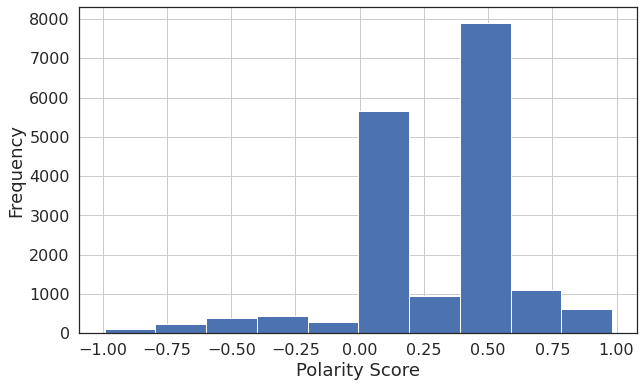

In [31]:
#Plotting the Polarity Scores' distribution, Bar Chart and Time-Series graphs

fig = plt.figure(figsize=(10, 6))
data_df['VComp'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [32]:
def get_value_counts(col_name):
    count = pd.DataFrame(data_df[col_name].value_counts())
    percentage = pd.DataFrame(data_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,1446,8.15
1,Neutral,5312,29.96
2,Positive,10975,61.89


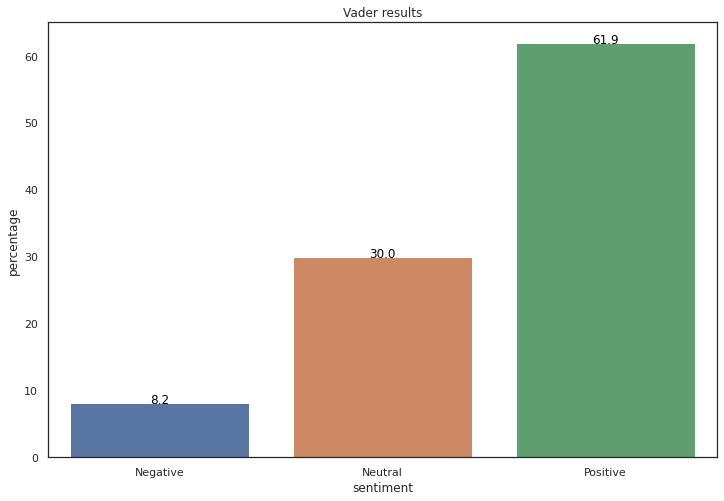

In [33]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('Vader results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

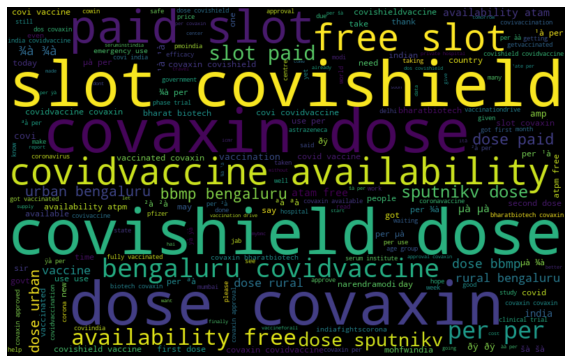

In [34]:
# create text from all tweets
all_words = ' '.join([text for text in data_df['CleanTweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

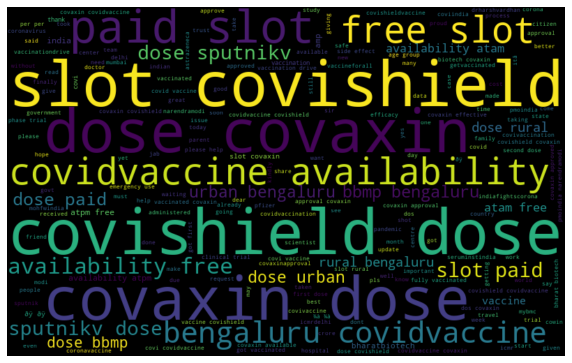

In [35]:
# create text from just positive tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

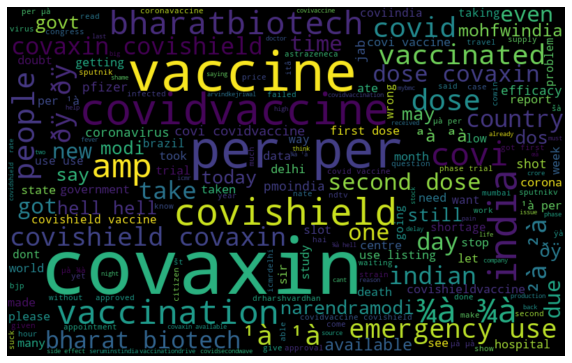

In [36]:
# create text from just negative tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

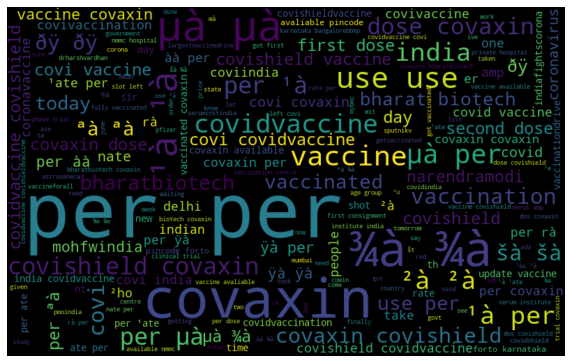

In [37]:
# create text from just neutral tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Neutral']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Understanding the impact of Hashtags on tweets sentiment**

In [38]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [39]:
# extracting hashtags from non racist/sexist tweets
HT_Positive = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Negative'])

# unnesting list
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])

In [40]:
print(HT_Positive)

['COVID19', 'COVAXINâ', 'Covaxinâ', 'Vaccine', 'BharatBiotech', 'CoronaVirusUpdates', 'CoronaVirusUpdate', 'CoronaUpdates', 'CoronaUpdate', 'Hyderabad', 'Telangana', 'CoronaVirusIndia', 'BREAKING', 'Indiaâ', 'COVID19', 'Covaxin', 'Telangana', 'Covid', 'Hyderabad', 'COVAXIN', 'vaccine', 'BharatBioTech', 'VaccinesWork', 'Hyderabad', 'SaveHumanRace', 'Covaxin', 'Vaccine', 'BharatBiotech', 'CoronaVirusUpdates', 'CoronaVirusUpdate', 'CoronaUpdates', 'CoronaUpdate', 'COVAXIN', 'DCGI', 'toiIndia', 'COVID19', 'Covaxin', 'COVAXIN', 'BharatBiotec', 'AtmaNirbharBharat', 'BharatBiotech', 'COVAXIN', 'covid19', 'Collaboration', 'Indiafightscorona', 'makeinindia', 'ICMRâ', 'DawnNewspaper', 'COVAXIN', 'COVID19', 'positivity', 'HOPE', 'Indians', 'love', 'COVAXIN', 'Covid_19', 'COVID19', 'COVAXIN', 'COVAXIN', 'BharatBiotech', 'COVAXIN', 'COVID19India', 'Vaccineswork', 'Indiafightscorona', 'COVAXIN', 'Covid_19', 'COVID19', 'COVAXIN', 'COVAXIN', 'COVAXIN', 'COVID19', 'wednesdaymorning', 'TrumpTraitor', 't

In [41]:
print(HT_Neutral)

['covaxin', 'Covaxin', 'Coronavaccine', 'COVAXIN', 'COVID19', 'serum_institute_india', 'covaxin', 'creconavirusapryppes', 'coronavirus', 'coronavirus', 'coronaruphancesinindia', 'Covaxin', 'coronavirus', 'Hyderabad', 'COVID19', 'India', 'BharatBiotech', 'COVAXIN', 'COVID19vaccine', 'IndiaFightsCorona', 'IndiaFightsCOVID19', 'COVIDUpdates', 'COVID19', 'COVAXIN', 'tuesdayvibes', 'coronavirus', 'Covid_19', 'icmcrdhlhhy', 'CoronaUpdatesInIndia', 'india', 'covid19', 'COVAXIN', 'COVID19', 'Covaxin', 'atmanirbharbharat', 'Bharatbiotech', 'BharatBiotech', 'COVID19', 'COVAXIN', 'Chinesevirusvaccine', 'xijingpingvaccine', 'Covaxin', 'COVAXIN', 'SURGICALSTRIKES', 'FIXED', 'RESERVED', 'PAKISTAN', 'Bharatbiotech', 'covaxin', 'cnbcta', 'suchitrevela', 'suchputa', 'covidvaccine', 'BreakingNews', 'COVAXIN', 'vaccine', 'COVID19', 'Bharatbiotech', 'indiatoday', 'krishnaella', 'covaxin', 'coronavaccine', 'Covaxin', 'COVAXIN', 'BharatBiotech', 'Covid_19', 'MadeinIndian', 'CoronaPandemic', 'COVAXIN', 'publ

In [42]:
print(HT_Negative)

['vaccine', 'COVAXIN', 'CoronaVaccine', 'covaxin', 'covixin', 'coronaupdatesinandia', 'corage', 'vaccine', 'COVAXIN', 'CoronaVaccine', 'Covaxinâ', 'Coronilâ', 'COVID19vaccine', 'ICMR', 'StayHomeStaySafe', 'COVIDãƒ¼19', 'lockdownextension', 'COVAXIN', 'CoronavirusIndia', 'COVID19India', 'CoronaWarriors', 'airborne', 'COVIDãƒ¼19', 'Airborne', 'humanity', 'coronavirus', 'COVID19India', 'COVIDãƒ¼19', 'COVAXIN', 'coronavirus', 'middaymeal', 'coronavaccine', 'COVID19', 'CoronavirusPandemic', 'IndiaFightsCorona', 'dolar', 'COVAXIN', 'COVIDIOTS', 'poverty', 'Covid', 'india', 'Reality', 'coronavirus', 'Covid_19', 'vaccine', 'IndiaFightsCorona', 'COVAXIN', 'Breaking', 'Ooxfunnate', 'coor19', 'covax19', 'tamilnuda', 'COovixinVaccine', 'AIIimsedheli', 'Coronavirus', 'Breaking', 'Oxfudunies', 'coronvacine', 'covid19', 'covaxin', 'tamilnadu', 'COVID19', 'COVID19', 'Covaxin', 'ICMRFIGHTSCOVID19', 'mondaythoughts', 'MondayMotivation', 'motivation', 'MotivationalQuotes', 'TruthWithRahulGandhiJi', 'Shei

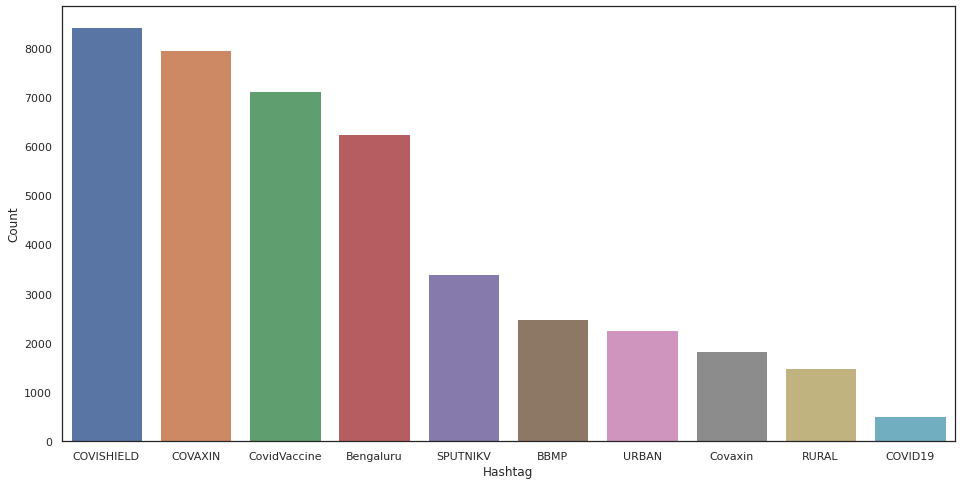

In [43]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

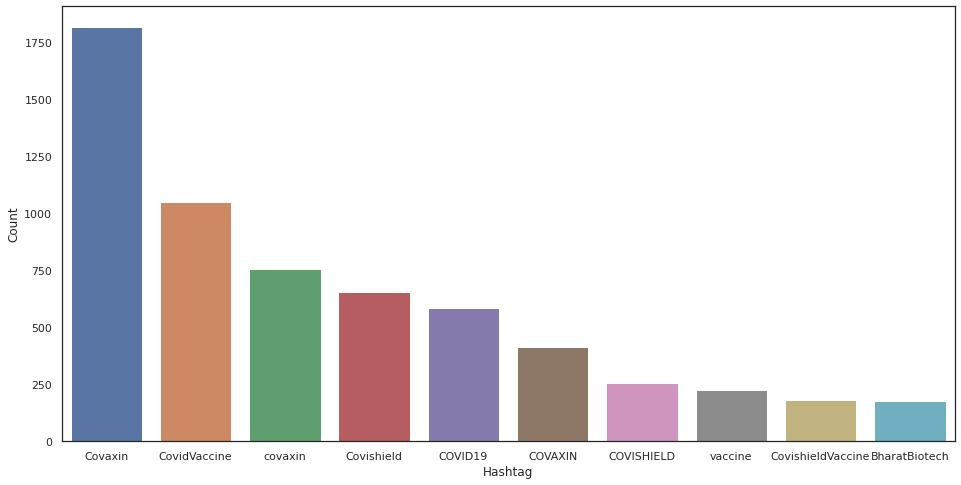

In [44]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

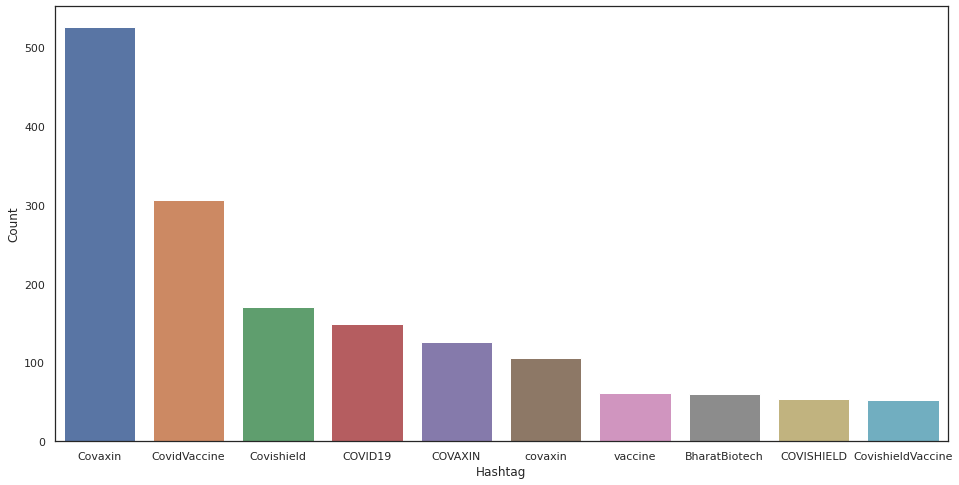

In [45]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

In [46]:
#Checking out the top 10 most Negative tweets (With Polarity of -1)
pd.set_option('display.max_colwidth', 400)
data_df.sort_values(by='TBScore', ascending=True)[['CleanTweet','TBScore','Username']].reset_index(drop=True).head(n=10)

,CleanTweet,TBScore,Username
0,vijai nihdirector worst scientist making unscientific noise covaxin,-1.0,neelbs
1,thehindu worst situation even dont covaxin covisheild ammyindiyeah,-1.0,Mohitka54152324
2,opposition state like kerala punjab an chhattisgarh refuse use covaxin even efficacy result insulting indiaâ€™s scientist sake politics shame,-1.0,RealVijayRaina
3,opposition state like kerala punjab chhattisgarh refuse use covaxin even efficacy result insulting indiaâ€™s scientist sake politics shame sycs,-1.0,sagrolikarBJP
4,dªμful across àthrtroach ¹àμμμμμμμμμμμμμ « anter à¹³μμμμμμμμt byofanthrough « « aforemention aforement worst worst addition aªta aªtrμ aªtrow ithak uustral covaxin tavel httpsravecotcowjqdb,-1.0,vtvgujarati
5,moneycontrolcom horrible headline given article written mrpillai covaxin trial gain puvlic attentikn scare monger benefit,-1.0,pgk5192
6,shame inspite efficacy result opposition state like kerala punjab chhattisgarh refuse use covaxin insulting indiaâ€™s scientist sake politics vaccinationdrive,-1.0,NaN
7,opposition state like kerala punjab an chhattisgarh refuse use covaxin even efficacy result insulting indiaâ€™s scientist sake politics shame sipej,-1.0,NaN
8,terrible reversal vaccine mania newsgod save childrenomcovaxin,-1.0,DrMMirajkar1
9,stevewi govcanhealth weâ€™ll wait till november covaxin approval insane,-1.0,himanshi2311


In [47]:
#Checking out the top 10 most Positive tweets (With Polarity of +1)
data_df.sort_values(by='TBScore', ascending=False)[['CleanTweet', 'TBScore', 'Username']].reset_index(drop=True).head(n=10)

,CleanTweet,TBScore,Username
0,bdutt drriteshmalik awesome one got covaxin covishield,1.0,Biorahul
1,got myst dose covaxin vaccinated hello everyone taking covi vaccination best step towards fighting pandemic take encourage family friend etc take getvaccinated phizer covid iplcancel coronavaccine,1.0,NaN
2,ðÿ ’ ‰ received dose vaccine ðÿ ’ ‰ thank narendramodi bharatbiotech pmcpune ajitpawarspeaks dada iasrubal moholmurlidhar pmchealthdept excellent management hospital staff kudos covaxin vaccinated sbb,1.0,NaN
3,dipshikhaghosh waiting best one come town covidshield nit approved covaxin,1.0,teenanz
4,sputnikvaccine already vaccinated best covaxin ðÿ™ bharatbiotech,1.0,MohitSRathore
5,dollyparton partly funded moderna covid vaccine research wonderful thing ðÿ™ðÿ™ðÿ™ anyone bollywood funding covaxin missed opportunity angel bollywood syxcig,1.0,tituraj
6,superb news indigenous vaccine covaxin approved child year ðÿ ‘ ðÿ¦¾âœœï¸ bharatbiotech covaxin,1.0,NaN
7,covidvaccine oxfordastrazencas covishield india best bet aarti subramaniam explains snumsetf,1.0,Mirror Now
8,raminations say modi bungled vaccination one call uddhav best term covaxin unreliablesome people never change,1.0,SudhirSrinath
9,dedicated waiting best vaccine covidvaccine astrazenaca covishield covivaccination covidnewsbymib jkjavmy,1.0,Sanjeev Rajput


Sentiment variation with respect to various months  

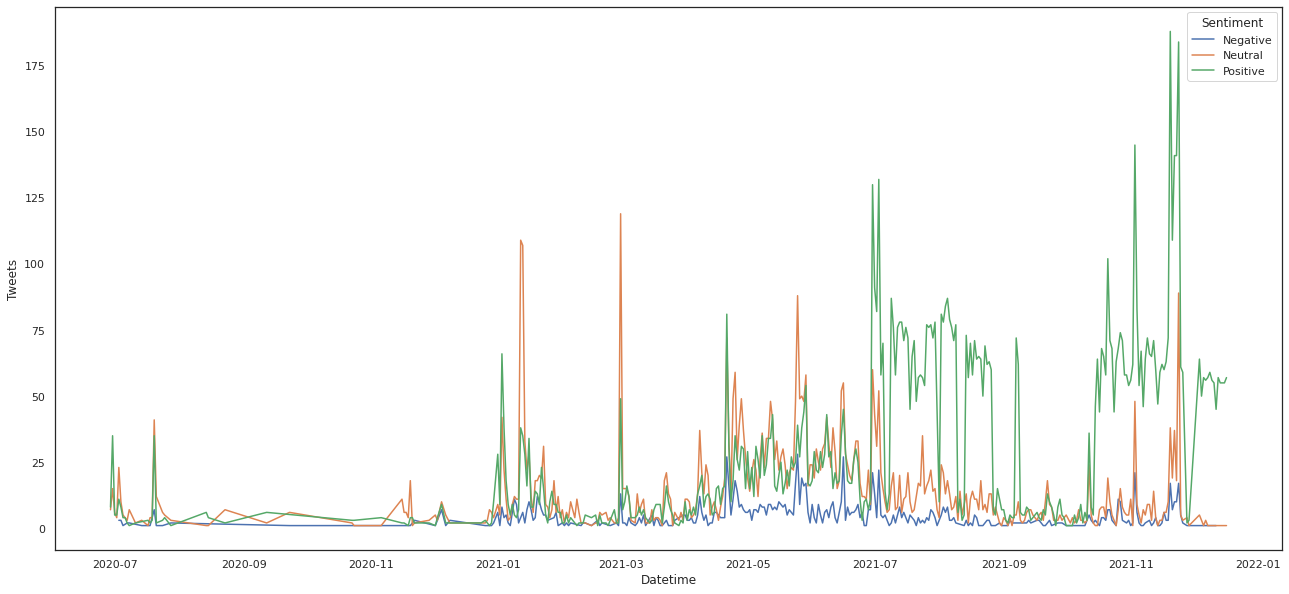

In [87]:
data_df["Datetime"] = data_df['Date']
timeline = data_df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)

#Checking count and frequency of various tweet words based on their sentiment 

Create a corpus for positive and negative tweets

In [48]:
data_df['TokenizeTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))

In [49]:
# positive tweets
positive_tweets = data_df[data_df['Sentiment']=='Positive']['TokenizeTweet']
print("Total positive tweets: ", len(positive_tweets))
positive_tweets_words = list(itertools.chain(*positive_tweets))
print("Total words in positive tweets:", len(positive_tweets_words))

# negative tweets
negative_tweets = data_df[data_df['Sentiment']=='Negative']['TokenizeTweet']
print("Total negative tweets: ", len(negative_tweets))
negative_tweets_words = list(itertools.chain(*negative_tweets))
print("Total words in negative tweets:", len(negative_tweets_words))

Total positive tweets:  10975
Total words in positive tweets: 196762
Total negative tweets:  1446
Total words in negative tweets: 31126


Estimate the word frequency in the corpus

In [50]:
positive_words_frequency = collections.Counter(positive_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common positive words:", positive_words_frequency.most_common(10))
negative_words_frequency = collections.Counter(negative_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common negative words:", negative_words_frequency.most_common(10))

Most common positive words: [('dose', 20163), ('do', 19014), ('slot', 12642), ('covaxin', 12121), ('covishield', 9399), ('covidvaccine', 7284), ('free', 6472), ('availability', 6301), ('paid', 6287), ('bengaluru', 6250)]
Most common negative words: [('covaxin', 1371), ('vaccine', 586), ('to¤', 483), ('covishield', 410), ('per¤', 379), ('covidvaccine', 361), ('at¤', 319), ('dose', 299), ('covi', 284), ('india', 241)]


Visualize the word counts

In [51]:
positive_freq_words_df = pd.DataFrame(positive_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(positive_freq_words_df)

           Word  Frequency
0          dose      20163
1            do      19014
2          slot      12642
3       covaxin      12121
4    covishield       9399
5  covidvaccine       7284
6          free       6472
7  availability       6301
8          paid       6287
9     bengaluru       6250


In [52]:
negative_freq_words_df = pd.DataFrame(negative_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(negative_freq_words_df)

           Word  Frequency
0       covaxin       1371
1       vaccine        586
2           to¤        483
3    covishield        410
4          per¤        379
5  covidvaccine        361
6           at¤        319
7          dose        299
8          covi        284
9         india        241


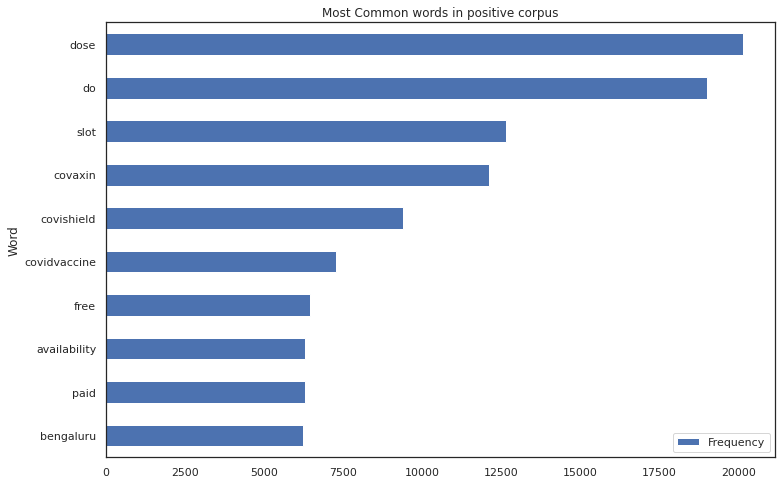

In [53]:
# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
positive_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in positive corpus")
plt.show()

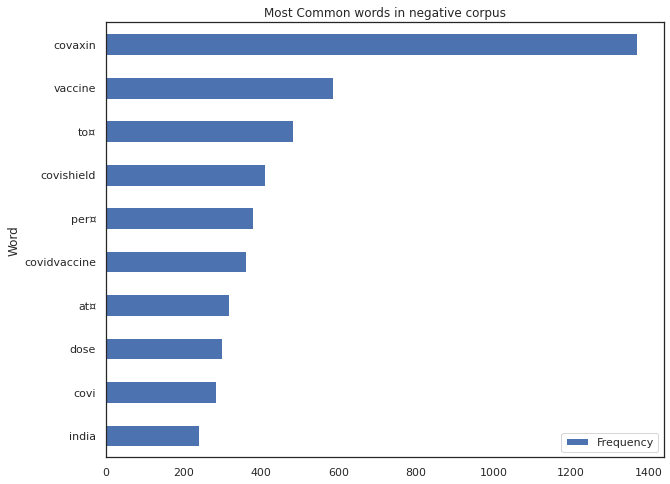

In [54]:
# set figure size
fig, ax = plt.subplots(figsize=(10, 8))
# plot horizontal bar plot
negative_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in negative corpus")
plt.show()

#Extracting Features from Cleaned Tweets

In [55]:
model_df = data_df[['CleanTweet','Sentiment']]

CONVRTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [56]:
model_df["Sentiment"]= model_df["Sentiment"].replace('Positive',1) 
model_df["Sentiment"]= model_df["Sentiment"].replace('Neutral',1) 
model_df["Sentiment"]= model_df["Sentiment"].replace('Negative',0) 


In [57]:
model_df.head()

,CleanTweet,Sentiment
0,indiaâ€™s first potential covi vaccine â€œcovaxinâ€ first developed india given dcgi drug controller general india approval phase human clinical trial scheduled start across country july,1
1,covaxinâ€ ” major breakthrough indiaâ€™s first covi vaccine developed bharatbiotech collaboration wid icmrniv get dgci approval phase human trial coronavirusupdates coronavirusupdate coronaupdates coronaupdate hyderabad telangana coronavirusindia,1
2,covaxin,1
3,breaking union health min approves clinical human trail indiaâ€™sst covi vaccine developed bharath biotech icmrniv covaxin successfully tested animal best wish btw remember telangana kcr said covid vaccine come hyderabad,1
4,covaxin first indian vaccine developed bharatbiotech bharatbiotech hope everything go well get vaccineswork asap know developed hyderabad savehumanrace,1


In [58]:
model_df['Sentiment'].value_counts()

1    16287
0     1446
Name: Sentiment, dtype: int64

In [59]:
X = model_df.drop('Sentiment', axis=1)
y = model_df.Sentiment

In [60]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
model_df['CleanTweet'].apply(lambda x: [item for item in x if item not in stop])

0        [n, â, €, ™,  , f, r,  , p, e, n, l,  , c, v,  , v, c, c, n, e,  , â, €, œ, c, v, x, n, â, €, ,  , f, r,  , e, v, e, l, p, e,  , n,  , g, v, e, n,  , c, g,  , r, u, g,  , c, n, r, l, l, e, r,  , g, e, n, e, r, l,  , n,  , p, p, r, v, l,  , p, h, e,  , h, u, n,  , c, l, n, c, l,  , r, l,  , c, h, e, ...]
1        [c, v, x, n, â, €,  , ”,  , j, r,  , b, r, e, k, h, r, u, g, h,  , n, â, €, ™,  , f, r,  , c, v,  , v, c, c, n, e,  , e, v, e, l, p, e,  , b, h, r, b, e, c, h,  , c, l, l, b, r, n,  , w,  , c, r, n, v,  , g, e,  , g, c,  , p, p, r, v, l,  , p, h, e,  , h, u, n,  , r, l,  , c, r, n, v, r, u, u, p, e, ...]
2                                                                                                                                                                                                                                                                                                             [c, v, x, n]
3        [b, r, e, k, n, g,  , u, n, n,  , h, e, l, h, 

In [62]:
model_df.head(5)

,CleanTweet,Sentiment
0,indiaâ€™s first potential covi vaccine â€œcovaxinâ€ first developed india given dcgi drug controller general india approval phase human clinical trial scheduled start across country july,1
1,covaxinâ€ ” major breakthrough indiaâ€™s first covi vaccine developed bharatbiotech collaboration wid icmrniv get dgci approval phase human trial coronavirusupdates coronavirusupdate coronaupdates coronaupdate hyderabad telangana coronavirusindia,1
2,covaxin,1
3,breaking union health min approves clinical human trail indiaâ€™sst covi vaccine developed bharath biotech icmrniv covaxin successfully tested animal best wish btw remember telangana kcr said covid vaccine come hyderabad,1
4,covaxin first indian vaccine developed bharatbiotech bharatbiotech hope everything go well get vaccineswork asap know developed hyderabad savehumanrace,1


In [63]:
#DIVIDING OUR DATASET INTO TRAINING AND TESTING
from sklearn.model_selection import train_test_split

train,valid = train_test_split(model_df,test_size = 0.2,random_state=0,stratify = model_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (14186, 2)
valid shape :  (3547, 2)


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.CleanTweet.values)
X_valid = vectorizer.transform(valid.CleanTweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (14186, 23805)
X_train.shape :  (3547, 23805)
y_train.shape :  (14186,)
y_valid.shape :  (3547,)


In [65]:
#NAIVE BAYES CLASSIFIER FOR BINARY CLASSIFICATION.
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.9170308755110672
Validation accuracy Score :  0.9128841274316324
              precision    recall  f1-score   support

           0       0.41      0.46      0.43       256
           1       0.96      0.95      0.95      3291

    accuracy                           0.91      3547
   macro avg       0.68      0.70      0.69      3547
weighted avg       0.92      0.91      0.92      3547



In [66]:
#RANDOM FOREST CLASSIFIER FOR BINARY CLASSIFICATION
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  1.0
Validation accuracy Score :  0.9382576825486326
              precision    recall  f1-score   support

           0       0.31      0.82      0.45       110
           1       0.99      0.94      0.97      3437

    accuracy                           0.94      3547
   macro avg       0.65      0.88      0.71      3547
weighted avg       0.97      0.94      0.95      3547



In [67]:
#LOGISTIC REGRESSION(BINARY CLASSIFICATION)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9918229240095869
Validation accuracy Score :  0.942768536791655
              precision    recall  f1-score   support

           0       0.38      0.82      0.52       136
           1       0.99      0.95      0.97      3411

    accuracy                           0.94      3547
   macro avg       0.69      0.88      0.75      3547
weighted avg       0.97      0.94      0.95      3547



In [68]:
#XG BOOST( BINARY CLASSIFICATION)
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.9266177921894826
Validation accuracy Score :  0.9250070482097548
              precision    recall  f1-score   support

           0       0.10      0.83      0.18        35
           1       1.00      0.93      0.96      3512

    accuracy                           0.93      3547
   macro avg       0.55      0.88      0.57      3547
weighted avg       0.99      0.93      0.95      3547



In [69]:
#SUPPORT VECTOR MACHINE(BINARY CLASSIFICATION)
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9352178203862963
Validation accuracy Score :  0.9204961939667324
              precision    recall  f1-score   support

           0       0.02      1.00      0.05         7
           1       1.00      0.92      0.96      3540

    accuracy                           0.92      3547
   macro avg       0.51      0.96      0.50      3547
weighted avg       1.00      0.92      0.96      3547



In [70]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9978147469335965
Validation accuracy Score :  0.9419227516210883
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       211
           1       0.98      0.96      0.97      3336

    accuracy                           0.94      3547
   macro avg       0.74      0.83      0.78      3547
weighted avg       0.95      0.94      0.95      3547



In [71]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
1,Logistic Regression,0.942769
4,Stochastic Gradient Decent,0.941923
2,Random Forest,0.938258
5,XGBoost,0.925007
0,Support Vector Machines,0.920496
3,Naive Bayes,0.912884


#Winner model Stochastic Gradient Decent

In [79]:
#LOGISTIC REGRESSION(BINARY CLASSIFICATION)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9918229240095869
Validation accuracy Score :  0.942768536791655
              precision    recall  f1-score   support

           0       0.38      0.82      0.52       136
           1       0.99      0.95      0.97      3411

    accuracy                           0.94      3547
   macro avg       0.69      0.88      0.75      3547
weighted avg       0.97      0.94      0.95      3547



In [80]:
# Get the predicted classes
train_class_preds = logreg.predict(X_train)
test_class_preds = logreg.predict(X_valid)

[[ 1042   115]
 [    1 13028]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

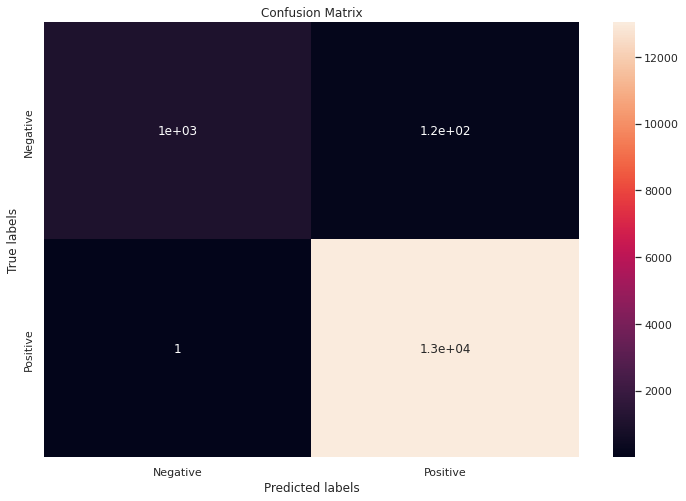

In [81]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Negative', 'Positive']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [82]:
# Let's check the overall accuracy. Overall accuracy is very good.
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = logreg.predict(X_valid)

score =accuracy_score(y_valid,y_pred)
print('accuracy is', score)

accuracy is 0.942768536791655


In [83]:
# F1 score for our classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred =  logreg.predict(X_valid)
print(f1_score(y_valid,y_pred, average="macro"))

0.7459567974738253


In [84]:
#score is mean accuracy
scikit_score = logreg.score(X_valid,y_valid)
print('scikit score:', scikit_score)

scikit score: 0.942768536791655


In [85]:
# Recall score for our winner model
recall_score(y_valid, y_pred, average='macro')

0.6882048128535349